In [1]:
import torch
import numpy as np
import os, sys, glob, copy
import matplotlib.pyplot as plt
import PIL.Image as Image
import pathlib
sys.path.insert(0, "../..")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"


sys.path.insert(0, "../")
import train
import notebooks.figure_generation.overlap_stitch as stitch_utils
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import dataset.precomp_dataset as ds
from models.get_model import get_model

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:1')

# LOAD

In [2]:
def from_weights_path(path):
    config_path = os.path.join(pathlib.Path(path).parent, "training_config.yml")
    config = helper.read_config(config_path)
    num_ims = config["forward_model_params"]["stack_depth"]

    config["data_precomputed"] = True
    config["preload_weights"] = True
    config["checkpoint_dir"] = path

    model = train.get_model(config=config, device=device)
    model.eval()
    return model

def preprocess_exp_meas(meas, ds_shape):
    meas = (meas/np.max(meas)).astype(np.float32)

    meas = np.stack([diffuser_utils.pyramid_down(slce, ds_shape) for slce in meas])
    meas = torch.tensor(meas)
    return meas

def patchwise_predict(meas : torch.Tensor, model_weights):
    # hardcoded
    meas = meas[:,1200-1260//2:1200+1260//2, 1970-1860//2:1970+1860//2]
    print(meas.shape)
    meas = preprocess_exp_meas(meas, (420, 620))
    patch_centers = stitch_utils.get_overlapping_positions((210, 310), (420,620), (256,256))
    
    prediction, contributions_mask = np.zeros((30,420,620)), np.zeros((420,620))
    for i, weights in enumerate(model_weights):
        model = from_weights_path(weights)

        # get patch centers relative to new cropped image and define this patch's region
        patchy, patchx = (256,256)
        ceny, cenx = patch_centers[i]
        reg = [ceny - patchy // 2 , ceny + patchy // 2 , cenx - patchx // 2, cenx + patchx // 2]
        print("Predicting region: ", reg)

        patch = meas[..., reg[0]:reg[1], reg[2]:reg[3]][None,:,None,...].to(device)
        pred = model.model2((patch - patch.mean()) / patch.std()).detach().cpu().numpy()
        
        # ------------ REMOVE NON IMAGE-BORDERING PATCH EDGE ARTIFACTS ----------- #
        crop_width = pred.shape[-1]//10 # assuming patch is square

        # Crop patch edges that are not bording an image edge
        bordering_top = (ceny - patchy // 2 == 0)
        bordering_bottom = (ceny + patchy // 2 == meas.shape[-2])
        bordering_right = (cenx + patchx // 2 == meas.shape[-1])
        bordering_left = (cenx - patchx // 2 == 0)
        if not bordering_top:
            pred, reg[0] = pred[..., crop_width:, :], reg[0] + crop_width
        if not bordering_bottom:
            pred, reg[1] = pred[..., :-crop_width, :], reg[1] - crop_width
        if not bordering_left:
            pred, reg[2] = pred[..., :, crop_width:], reg[2] + crop_width
        if not bordering_right:
            pred, reg[3] = pred[..., :, :-crop_width], reg[3] - crop_width


        # Insert the cropped patch into the prediction array
        prediction[..., reg[0]:reg[1], reg[2]:reg[3]] += pred.squeeze()
        contributions_mask[reg[0]:reg[1], reg[2]:reg[3]] += 1
        del model, pred

    pred = prediction / contributions_mask

    return pred.transpose(1,2,0)


In [86]:
patch_weights_paths = [
    "/home/cfoley/defocuscamdata/models/checkpoint_results_learned_patch1_config.yml/2024_03_15_04_28_43/saved_model_ep28_testloss_0.06951126177742514.pt",
    #"/home/cfoley/defocuscamdata/models/checkpoint_results_learned_patch1_nol1mask_config.yml/2024_03_16_16_35_31/saved_model_ep15_testloss_0.06806887185447058.pt",
    "/home/cfoley/defocuscamdata/models/checkpoint_results_learned_patch2_config.yml/2024_03_15_23_15_00/saved_model_ep22_testloss_0.059381735748347805.pt",
    "/home/cfoley/defocuscamdata/models/checkpoint_results_learned_patch3_config.yml/2024_03_16_04_53_02/saved_model_ep22_testloss_0.06674808305951785.pt",
    "/home/cfoley/defocuscamdata/models/checkpoint_results_learned_patch4_config.yml/2024_03_16_07_03_25/saved_model_ep22_testloss_0.07412154000814793.pt",
    "/home/cfoley/defocuscamdata/models/checkpoint_results_learned_patch5_config.yml/2024_03_16_09_11_33/saved_model_ep24_testloss_0.06324130734253042.pt",
    "/home/cfoley/defocuscamdata/models/checkpoint_results_learned_patch6_config.yml/2024_03_16_11_19_34/saved_model_ep12_testloss_0.05912848955617761.pt"
]

In [87]:
#exp_meas_path = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/03_07/exp_meas/color_palette"
exp_meas_path = "/home/cfoley/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/duckincar"
exp_meas = np.stack([Image.open(meas) for meas in sorted(glob.glob(os.path.join(exp_meas_path, "*.bmp")))])[0::4]
print(exp_meas.shape)

(2, 2048, 3072)


In [88]:
pred = patchwise_predict(exp_meas, patch_weights_paths)

(2, 1260, 1860)


Reading psf: 100%|██████████| 5/5 [00:00<00:00, 21.69it/s]


Scaled psfs by values: [1.0, 0.03171602604494854]
Predicting region:  [0, 256, 0, 256]


Reading psf: 100%|██████████| 5/5 [00:00<00:00, 17.90it/s]


Scaled psfs by values: [1.0, 0.03171602604494854]
Predicting region:  [0, 256, 182, 438]


Reading psf: 100%|██████████| 5/5 [00:00<00:00, 18.49it/s]


Scaled psfs by values: [1.0, 0.03171602604494854]
Predicting region:  [0, 256, 364, 620]


Reading psf: 100%|██████████| 5/5 [00:00<00:00, 21.94it/s]


Scaled psfs by values: [1.0, 0.03171602604494854]
Predicting region:  [164, 420, 0, 256]


Reading psf: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


Scaled psfs by values: [1.0, 0.03171602604494854]
Predicting region:  [164, 420, 182, 438]


Reading psf: 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


Scaled psfs by values: [1.0, 0.03171602604494854]
Predicting region:  [164, 420, 364, 620]


In [90]:
plot = (pred - np.min(pred))/np.max(pred-np.min(pred))
#bias = np.mean(plot[345:395, 535:595], axis=(0,1))
#white_balance = np.maximum(np.mean(helper.value_norm(plot - bias)[345:385, 80:135], axis=(0,1)),0 )
#bias = np.load("/home/cfoley/defocuscamdata/recons/exp_results_figure/true_black_bias.npy")

In [95]:
plot_vmax = np.clip(plot, np.min(plot), np.quantile(plot,0.99))

In [96]:
helper.plot_cube_interactive((helper.value_norm(plot_vmax))[:,:,:], fc_range=(390, 870), avg_block_size=5, fc_scaling=(1.2, 1, 0.8))

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'f5e5316b-c75b-4cfd-9a6a-c056cdf2c181',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 85, 102, 127],
                           [ 55,  59,  80],
                           [ 54,  57,  76],
                           ..., 
                           [115, 130,  93],
                           [110, 127,  99],
                           [131, 160, 154]],
                   
                          [[ 59,  64,  81],
                           [ 44,  47,  62],
                           [ 44,  47,  61],
                           ..., 
                           [114, 127,  83],
                           [107, 119,  77],
                           [115, 134, 112]],
                   
                          [[ 49,  51,  63],
                           [ 42,  44,  57],
                           [ 44,  46,  58],
                           ..., 
                           [111, 124

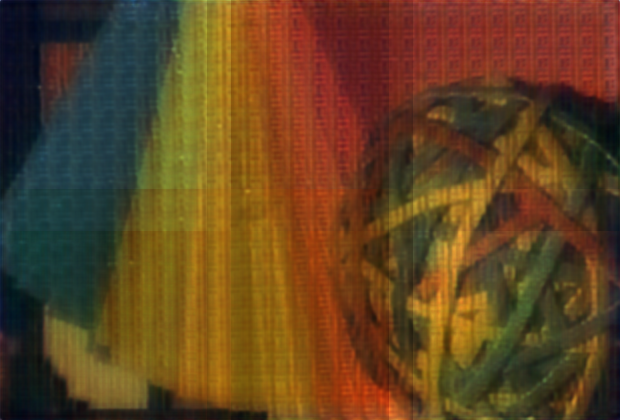

In [126]:
scaling = (1.2, 1, 0.8)
prp = helper.value_norm(plot - bias)
im = Image.fromarray((helper.value_norm(helper.select_and_average_bands(prp, fc_range=(390,870), scaling=scaling))*255).astype(np.uint8))

np.save(os.path.join("/home/cfoley/defocuscamdata/recons/exp_results_figure/", os.path.basename(exp_meas_path)), prp)
im.save(os.path.join("/home/cfoley/defocuscamdata/recons/exp_results_figure/", os.path.basename(exp_meas_path) + f"scaling{scaling}" + ".png"))

im

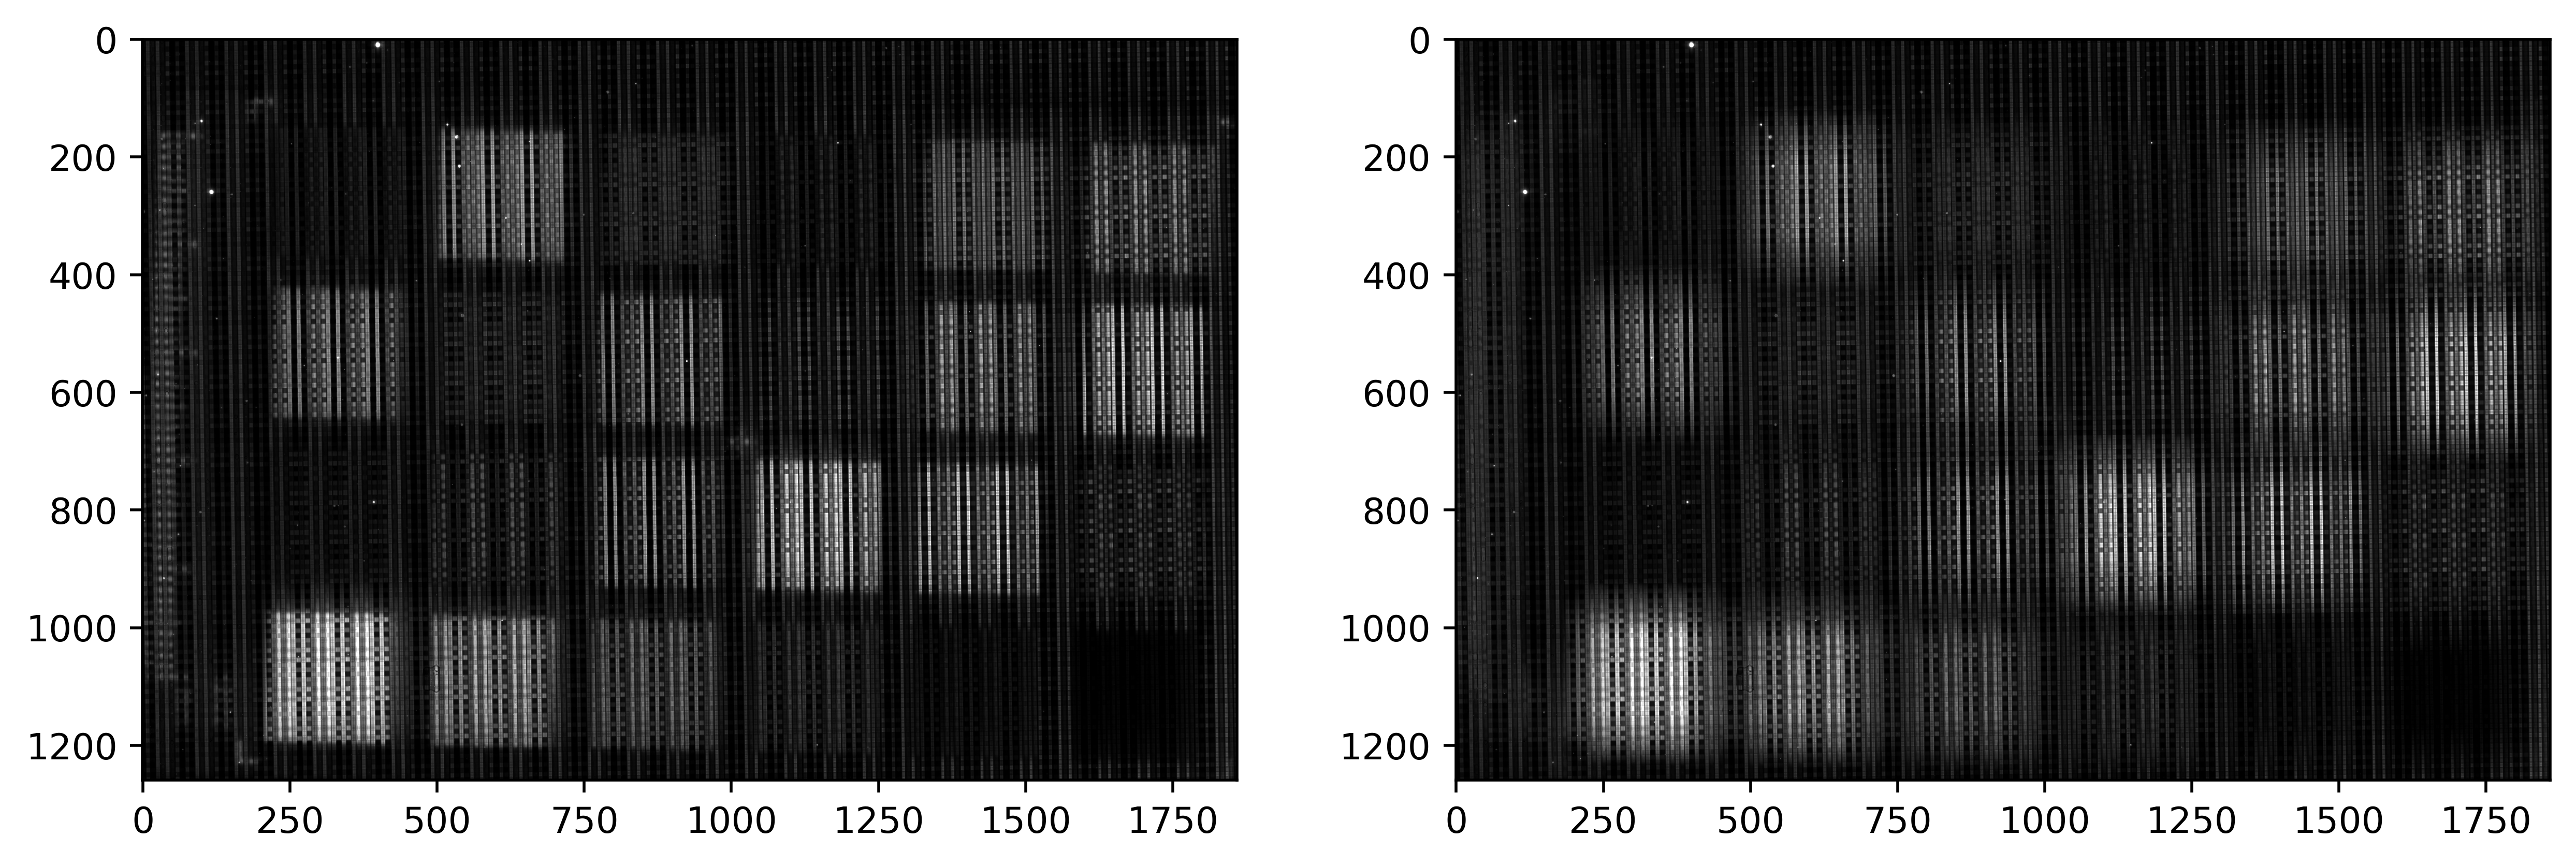

In [134]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
for i in range(2):
    ax[i].imshow(exp_meas[i,1200-1260//2:1200+1260//2, 1970-1860//2:1970+1860//2], cmap='gray')
plt.show()

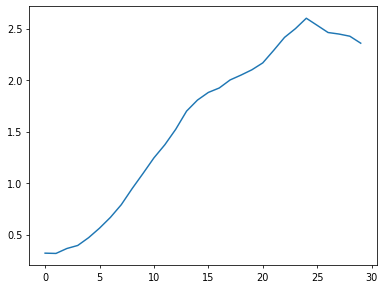

In [11]:
plt.figure(dpi = 70)
plt.plot(bias.squeeze())

In [158]:
bias.shape

(1, 620, 30)